# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Read Data

In [2]:
df = pd.read_csv("BFS Data.csv")
df.head()

,Country,Country Code,Series,Series Code,2023Q2 [2023Q2],2023Q3 [2023Q3],2023Q4 [2023Q4],2024Q1 [2024Q1],2024Q2 [2024Q2],2024Q3 [2024Q3],2024Q4 [2024Q4],2025Q1 [2025Q1],2025Q2 [2025Q2],2025Q3 [2025Q3]
0,Advanced Economies,AME,"Core CPI,not seas.adj,,,",CORENS,..,..,..,..,..,..,..,..,..,..
1,Advanced Economies,AME,"Core CPI,seas.adj,,,",CORESA,..,..,..,..,..,..,..,..,..,..
2,Advanced Economies,AME,"CPI Price, % y-o-y, median weighted, seas. adj.,",CPTOTSAXMZGY,..,..,..,..,..,..,..,..,..,..
3,Advanced Economies,AME,"CPI Price, % y-o-y, not seas. adj.,,",CPTOTSAXNZGY,..,..,..,..,..,..,..,..,..,..
4,Advanced Economies,AME,"CPI Price, seas. adj.,,,",CPTOTSAXN,..,..,..,..,..,..,..,..,..,..


In [3]:
df.shape
df.columns
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          627 non-null    object
 1   Country Code     625 non-null    object
 2   Series           625 non-null    object
 3   Series Code      625 non-null    object
 4   2023Q2 [2023Q2]  625 non-null    object
 5   2023Q3 [2023Q3]  625 non-null    object
 6   2023Q4 [2023Q4]  625 non-null    object
 7   2024Q1 [2024Q1]  625 non-null    object
 8   2024Q2 [2024Q2]  625 non-null    object
 9   2024Q3 [2024Q3]  625 non-null    object
 10  2024Q4 [2024Q4]  625 non-null    object
 11  2025Q1 [2025Q1]  625 non-null    object
 12  2025Q2 [2025Q2]  625 non-null    object
 13  2025Q3 [2025Q3]  625 non-null    object
dtypes: object(14)
memory usage: 69.0+ KB


Country            3
Country Code       5
Series             5
Series Code        5
2023Q2 [2023Q2]    5
2023Q3 [2023Q3]    5
2023Q4 [2023Q4]    5
2024Q1 [2024Q1]    5
2024Q2 [2024Q2]    5
2024Q3 [2024Q3]    5
2024Q4 [2024Q4]    5
2025Q1 [2025Q1]    5
2025Q2 [2025Q2]    5
2025Q3 [2025Q3]    5
dtype: int64

##  Data Cleaning 

Data Cleaning Summary
- Converted ".." and other markers to NaN
- Converted quarter columns to numeric
- Dropped rows with no quarter values
- Handled duplicates

In [4]:

# 4. DATA CLEANING 

# 4.1 Normalize column names (remove bracketed parts, trim spaces)
rename_map = {}
for c in df.columns:
   new_c = re.sub(r'\s*\[.*\]\s*', '', c).strip()
   rename_map[c] = new_c
df.rename(columns=rename_map, inplace=True)
# 4.2 Trim whitespace in string cells
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# 4.3 Identify quarter columns robustly (YYYYQ1..YYYYQ4)
qcols = [c for c in df.columns if re.fullmatch(r'\d{4}Q[1-4]', c)]
# Sort quarters chronologically (ensures comparisons like c < "2025Q1" are safe)
qcols = sorted(qcols, key=lambda s: (int(s[:4]), int(s[-1])))
# 4.4 Replace common missing markers with NaN
missing_markers = ['..', '', 'NA', 'N/A', 'na', '-', '–', '—']
df.replace(missing_markers, np.nan, inplace=True)
# 4.5 Convert quarter columns to numeric (coerce bad strings to NaN)
for c in qcols:
   df[c] = pd.to_numeric(df[c], errors='coerce')
# 4.6 Impute NUMERIC quarter columns with their COLUMN MEAN (includes target 2025Q1)
for c in qcols:
   col_mean = df[c].mean(skipna=True)
   # If a column is entirely NaN, col_mean will be NaN; leave it as-is (we won't use empty future quarters anyway)
   if not np.isnan(col_mean):
       df[c] = df[c].fillna(col_mean)
# 4.7 Handle categorical missingness (Country): fill with most frequent
if 'Country' in df.columns and df['Country'].isna().any():
   df['Country'] = df['Country'].fillna(df['Country'].mode(dropna=True).iloc[0])
# 4.8 Optional: drop rows that still have all-NaN in quarters (should be none after mean impute)
if any(df[qcols].isna().all(axis=1)):
   df = df[~df[qcols].isna().all(axis=1)].reset_index(drop=True)
# 4.9 FINAL CHECKS
print("Any NaN in target 2025Q1?", df['2025Q1'].isna().sum())
print("Any NaN left in used quarter columns?", df[qcols].isna().sum().sum())

Any NaN in target 2025Q1? 0
Any NaN left in used quarter columns? 630


In [14]:
assert '2025Q1' in df.columns, "Target 2025Q1 column missing."
assert df['2025Q1'].isna().sum() == 0, "Target still has NaN after mean imputation."
for c in [c for c in qcols if c < '2025Q1']:
   assert df[c].isna().sum() == 0, f"{c} still has NaN after mean imputation."

## Distribution of one example quarter

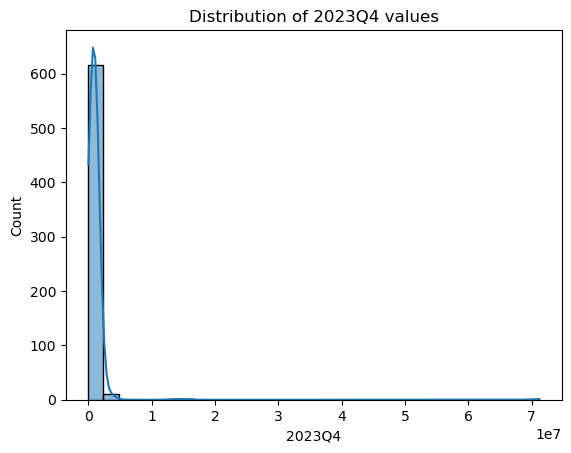

In [6]:
sns.histplot(df["2023Q4"].dropna(), bins=30, kde=True)
plt.title("Distribution of 2023Q4 values")
plt.show()

## Distribution of one example quarter

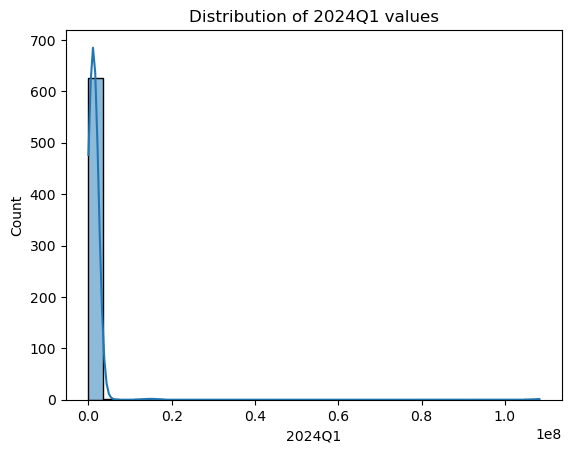

In [7]:
sns.histplot(df["2024Q1"].dropna(), bins=30, kde=True)
plt.title("Distribution of 2024Q1 values")
plt.show()

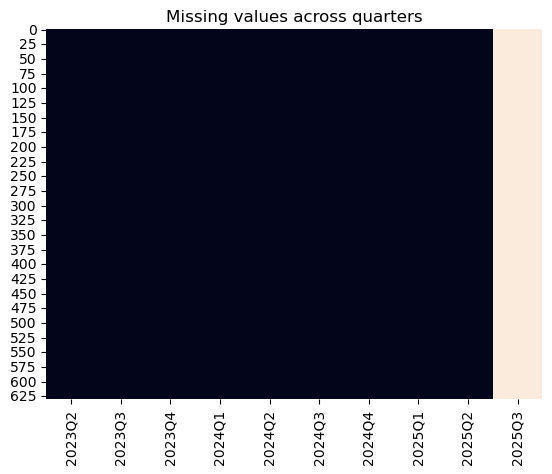

In [8]:
sns.heatmap(df[qcols].isnull(), cbar=False)
plt.title("Missing values across quarters")
plt.show()

# Correlation matrix for numeric columns


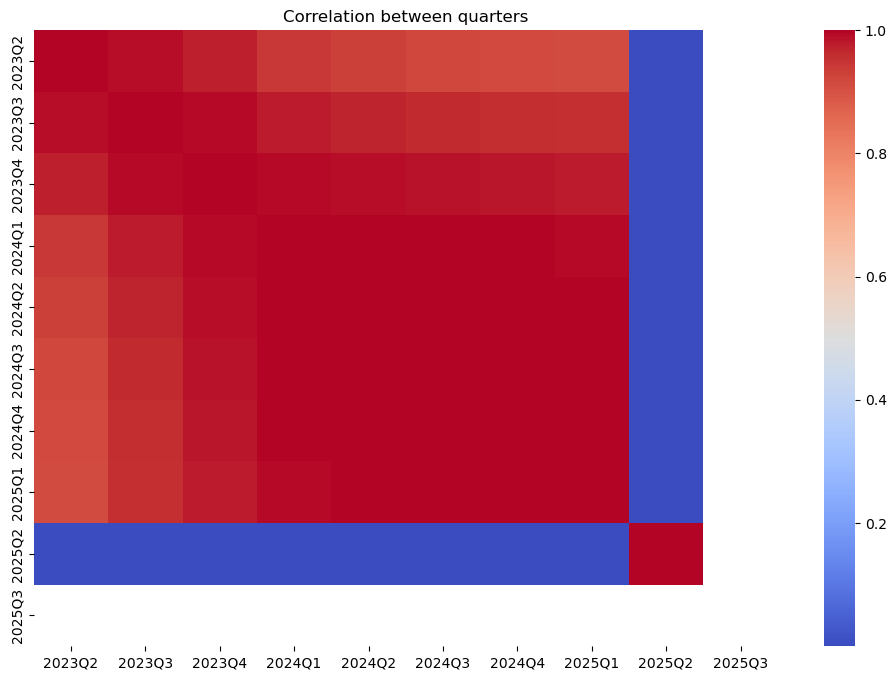

In [9]:
corr = df[qcols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation between quarters")
plt.show()

#  Predicting Business Formation Across Countries
- **Goal:** Use Business Formation Statistics quarterly indicators to predict future values.
- **Key Questions:**
 1. What are the most important features of the dataset?
 2. What insights can we gather?
 3. How accurate is the model?
 4. What happens in a creative predictive scenario?

# What are the most important features of the dataset?

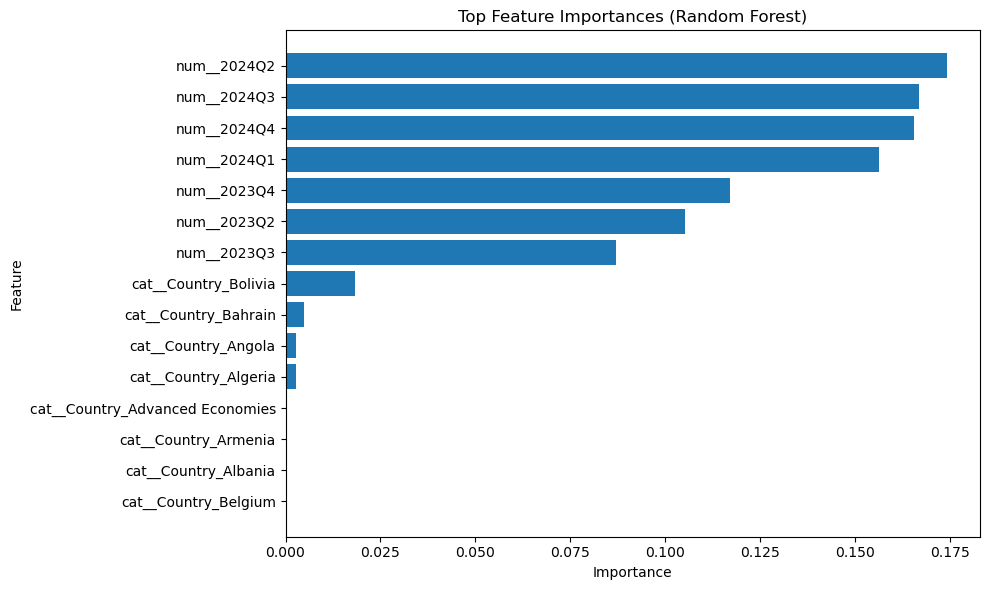

,feature,importance
31,num__2024Q2,1.741399e-01
32,num__2024Q3,1.666755e-01
33,num__2024Q4,1.655055e-01
30,num__2024Q1,1.561877e-01
29,num__2023Q4,1.171055e-01
27,num__2023Q2,1.051244e-01
28,num__2023Q3,8.690349e-02
22,cat__Country_Bolivia,1.824100e-02
13,cat__Country_Bahrain,4.780380e-03
4,cat__Country_Angola,2.651857e-03


In [18]:

# 9. FEATURE IMPORTANCE (Random Forest)
# Extract transformed feature names
feature_names = rf_model.named_steps["preprocessor"].get_feature_names_out(cat_cols + num_cols)
# Get importances
importances = rf_model.named_steps["regressor"].feature_importances_
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(
   "importance", ascending=False
)
# Plot top 15
top_k = 15
plt.figure(figsize=(10, 6))
plt.barh(feat_imp.head(top_k)["feature"][::-1], feat_imp.head(top_k)["importance"][::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
feat_imp.head(top_k)

In [15]:
# =========================
# 6. FEATURE/TARGET SPLIT
# =========================
# Use previous quarters as features, predict the most recent quarter
target = "2025Q1"# last two quarters are blank hence the use of "2025Q1" as the target variable

# Use only quarters before 2025Q1 + Country
features = ["Country"] + [c for c in qcols if c < target] # country + earlier quarters
X = df[features]
y = df[target]
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)
X_train.head()

,Country,2023Q2,2023Q3,2023Q4,2024Q1,2024Q2,2024Q3,2024Q4
335,Bahrain,3.034444,2.981918,3.175000,3.237474e+00,2.909955e+00,3.027984e+00,3.211757e+00
6,Advanced Economies,736362.861774,828634.929960,962664.079019,1.301221e+06,1.492617e+06,1.707047e+06,1.823903e+06
104,Angola,736362.861774,828634.929960,962664.079019,1.301221e+06,1.492617e+06,1.707047e+06,1.823903e+06
114,Angola,736362.861774,828634.929960,962664.079019,1.301221e+06,1.492617e+06,1.707047e+06,1.823903e+06
533,Bhutan,736362.861774,828634.929960,962664.079019,1.301221e+06,1.492617e+06,1.707047e+06,1.823903e+06


In [21]:

# 7. PREPROCESSING + MODELS 

# Target is 2025Q1 (2025Q2, 2025Q3 are empty hence they are excluded)
target = "2025Q1"
# Use all quarters strictly BEFORE 2025Q1 as numeric features + Country as categorical
cat_cols = ["Country"]
num_cols = [c for c in qcols if c < target]   # e.g., 2023Q2 → 2024Q4
features = cat_cols + num_cols
# Feature & target matrices
X = df[features].copy()
y = df[target].copy()
# Safety checks (should print 0)
print("NaNs in X[num_cols]:", X[num_cols].isna().sum().sum())
print("NaNs in y:", y.isna().sum())
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)
# Preprocessor:
# - We already imputed numeric means during cleaning, so just scale numerics.
# - Categorical: impute most_frequent  then one-hot encode with handle_unknown='ignore'
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer([
   ("cat", Pipeline([
       ("imputer", SimpleImputer(strategy="most_frequent")),
       ("encoder", OneHotEncoder(handle_unknown="ignore"))
   ]), cat_cols),
   ("num", Pipeline([
       # No imputer here because we've already filled means in cleaning.
       ("scaler", StandardScaler())
   ]), num_cols)
])
# Build pipelines
linreg_model = Pipeline([
   ("preprocessor", preprocessor),
   ("regressor", LinearRegression())
])
rf_model = Pipeline([
   ("preprocessor", preprocessor),
   ("regressor", RandomForestRegressor(n_estimators=300, random_state=42))
])
# Fit
linreg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

NaNs in X[num_cols]: 0
NaNs in y: 0


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['2023Q2', '2023Q3', '2023Q4',
                                                   '2024Q1', '2024Q2', '2024Q3',
                                                   '2024Q4'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=300, random_state=42))])

In [17]:

# 8. EVALUATION 

from sklearn.metrics import mean_squared_error, r2_score
# Predict
y_pred_lin = linreg_model.predict(X_test)
y_pred_rf  = rf_model.predict(X_test)
# Metrics
print("Linear Regression → R²:", r2_score(y_test, y_pred_lin),
     "RMSE:", mean_squared_error(y_test, y_pred_lin, squared=False))
print("Random Forest     → R²:", r2_score(y_test, y_pred_rf),
     "RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))

Linear Regression → R²: 0.8475182094793892 RMSE: 317843.5187098588
Random Forest     → R²: 0.9760971583937326 RMSE: 125843.02093966144


In [20]:
#=========================
# 10. CREATIVE PREDICTIVE SCENARIO
# =========================
# Use a template row from X_test and tweak it
scenario_df = X_test.iloc[[0]].copy()   
# Unseen country — encoder will ignore unknown 
scenario_df.loc[:, "Country"] = "Econland"
# Simulate +10% growth in the latest available feature quarter (2024Q4)
if "2024Q4" in scenario_df.columns:
   scenario_df.loc[:, "2024Q4"] = scenario_df["2024Q4"].astype(float) * 1.10
# Predict 2025Q1
pred = rf_model.predict(scenario_df)[0]
print(f"Predicted {target} for Econland (with +10% 2024Q4): {pred:.2f}")

Predicted 2025Q1 for Econland (with +10% 2024Q4): 2186290.00
